# Flocking Example

For this example, agents implement the
standard flocking goal of reaching consensus in velocities
while staying a fixed distance away from all other agents.
The constant sheaf $\underline{\R}^4$ on a fully connected communication
topology along with potential functions summing the stan-
dard consensus potential function on the velocity components
and the fixed distance potential function with $r^2 = 5$ on the
position components. Each agents’ objective is to minimize
total control activation. Additionally, a designated leader
agent tracks a constant rightward velocity vector. The results
of this controller run for 65 iterations are shown below.
Computing the distance between each agent confirms that
they reached the desired pairwise distance of $\sqrt{5}$.

In [1]:
using Test
using AlgebraicOptimization
using LinearAlgebra
using BlockArrays
using Plots
include("../../../examples/paper-examples/PaperPlotting.jl")
using .PaperPlotting

Set up each agent's dynamics: $x(t+1) = Ax(t) + Bu(t)$

In [2]:
dt = 0.1 # Discretization step size
A = [1 dt 0 0; 0 1 0 0; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt 0; 0 0; 0 dt]
C = [1 0 0 0; 0 0 1 0]
system = DiscreteLinearSystem(A, B, C)

DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0; 0 0 1 0])

Initialize the weight matrices such that the objective only concerns velocities

In [3]:
Q_leader = [0 0 0 0; 0 50 0 0; 0 0 0 0; 0 0 0 50]
Q_follower = zeros(4, 4)
R = I(2)

2×2 LinearAlgebra.Diagonal{Bool, Vector{Bool}}:
 1  ⋅
 ⋅  1

Define the parameters for the MPC

In [4]:
N = 10
control_bounds = [-2.0, 2.0]
params1 = MPCParams(Q_leader, R, system, control_bounds, N, [0.0, 1.0, 0.0, 0.0])
params2 = params3 = MPCParams(Q_follower, R, system, control_bounds, N)

MPCParams([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], Bool[1 0; 0 1], DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0; 0 0 1 0]), [-2.0, 2.0], 10, [0.0, 0.0, 0.0, 0.0])

Define the potential functions

$q(x) = (x' * x - 5.0)^2$

$p(x) = [x[2], x[4]]' * [x[2], x[4]] + q([x[1], x[3]])$

In [5]:
q(x) = (x' * x - 5.0)^2
p(x) = [x[2], x[4]]' * [x[2], x[4]] + q([x[1], x[3]])

p (generic function with 1 method)

Define the constant sheaf

In [6]:
c = PotentialSheaf([4, 4, 4], [2, 2, 2], [q, q, q])
set_edge_maps!(c, 1, 2, 1, C, C)
set_edge_maps!(c, 1, 3, 2, C, C)
set_edge_maps!(c, 2, 3, 3, C, C)

2×4 Matrix{Int64}:
 -1  0   0  0
  0  0  -1  0

Set up solver to perform MPC and solve the optimization problem with ADMM

In [7]:
x_init = BlockArray(rand(12), c.vertex_stalks)
prob = MultiAgentMPCProblem([params1, params1, params1], c, x_init)
alg = NonConvexADMM(1000.0, 10, 0.0001, 5000)
num_iters = 200

200

Run solver on MPC

In [8]:
trajectory, controls = do_mpc!(prob, alg, num_iters)

(Any[[0.31584192442803416, 0.7644374379605758, 0.5740952423792296, 0.46793449571073553, 0.5641800594467559, 0.32240294870118635, 0.6923698645571896, 0.5239352625387911, 0.3351722168994953, 0.8593329511853889, 0.6738948419531572, 0.43840373105858266], [0.3922856682240917, 0.8699451635917287, 0.6208886919503032, 0.26793449791198853, 0.5964203543168745, 0.5224029495844092, 0.7447633908110687, 0.32393526304519316, 0.42110551201803414, 0.9173193723447031, 0.7177352150590155, 0.2384037387926102], [0.4792801845832646, 0.9224463053081012, 0.647682141741502, 0.13257032046676426, 0.6486606492753154, 0.7224029434365358, 0.777156917115588, 0.16045634987993368, 0.5128374492525045, 0.9460793785557174, 0.7415755889382765, 0.11761731051903082], [0.5715248151140747, 0.9484933054152592, 0.6609391737881783, 0.06476726041015321, 0.720900943618969, 0.8477165209410691, 0.7932025521035814, 0.07848784369464173, 0.6074453871080763, 0.9602611700809421, 0.7533373199901795, 0.05711172019147637], [0.66637414565560

Plot results

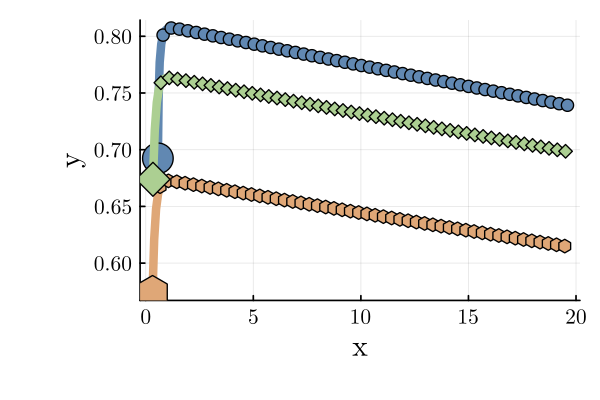

In [9]:
PaperPlotting.plot_trajectories(trajectory, C)